# Classification with an Academic Success Dataset

## Exploratory Data Analysis

In [7]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [13]:
print("Dataset shape (rows, columns):", train.shape)

Dataset shape (rows, columns): (76518, 38)


In [14]:
print("First 5 rows:")
train.head()

First 5 rows:


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [15]:
print("\nStatistical summary:")
train.describe()


Statistical summary:


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,...,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,38258.500000,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,...,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,22088.988286,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,...,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,0.000000,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,19129.250000,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,...,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,38258.500000,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,...,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,57387.750000,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,...,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,76517.000000,6.000000,53.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,...,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


In [16]:
print("\nMissing values in each column:")
train.isnull().sum()


Missing values in each column:


id                                                0
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship 

In [17]:
print("\nNumber of duplicate rows:")
print(train.duplicated().sum())

print("\nUnique classes:")
print(train['Target'].unique())


Number of duplicate rows:
0

Unique classes:
['Graduate' 'Dropout' 'Enrolled']


In [18]:
print("\nDataset information:")
train.info()


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualific

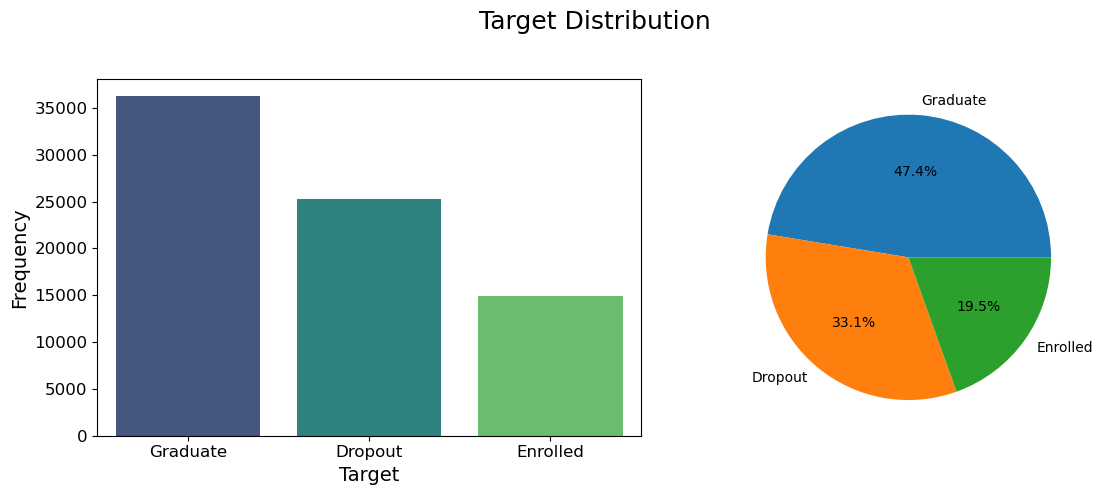

In [19]:
target_counts = train['Target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sb.barplot(
    x=target_counts.index,
    y=target_counts.values,
    hue=target_counts.index,
    palette="viridis",
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Pie chart
axes[1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct='%1.1f%%'
)

fig.suptitle("Target Distribution", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [9]:
cat_vars = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
            'Previous qualification	', 'Nacionality', "Mother's qualification",
            "Father's qualification", "Mother's occupation", "Father's occupation",
            'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
            'Gender', 'Scholarship holder', 'International']

num_features = [col for col in train.columns if col not in cat_vars + ['id', 'Target']]

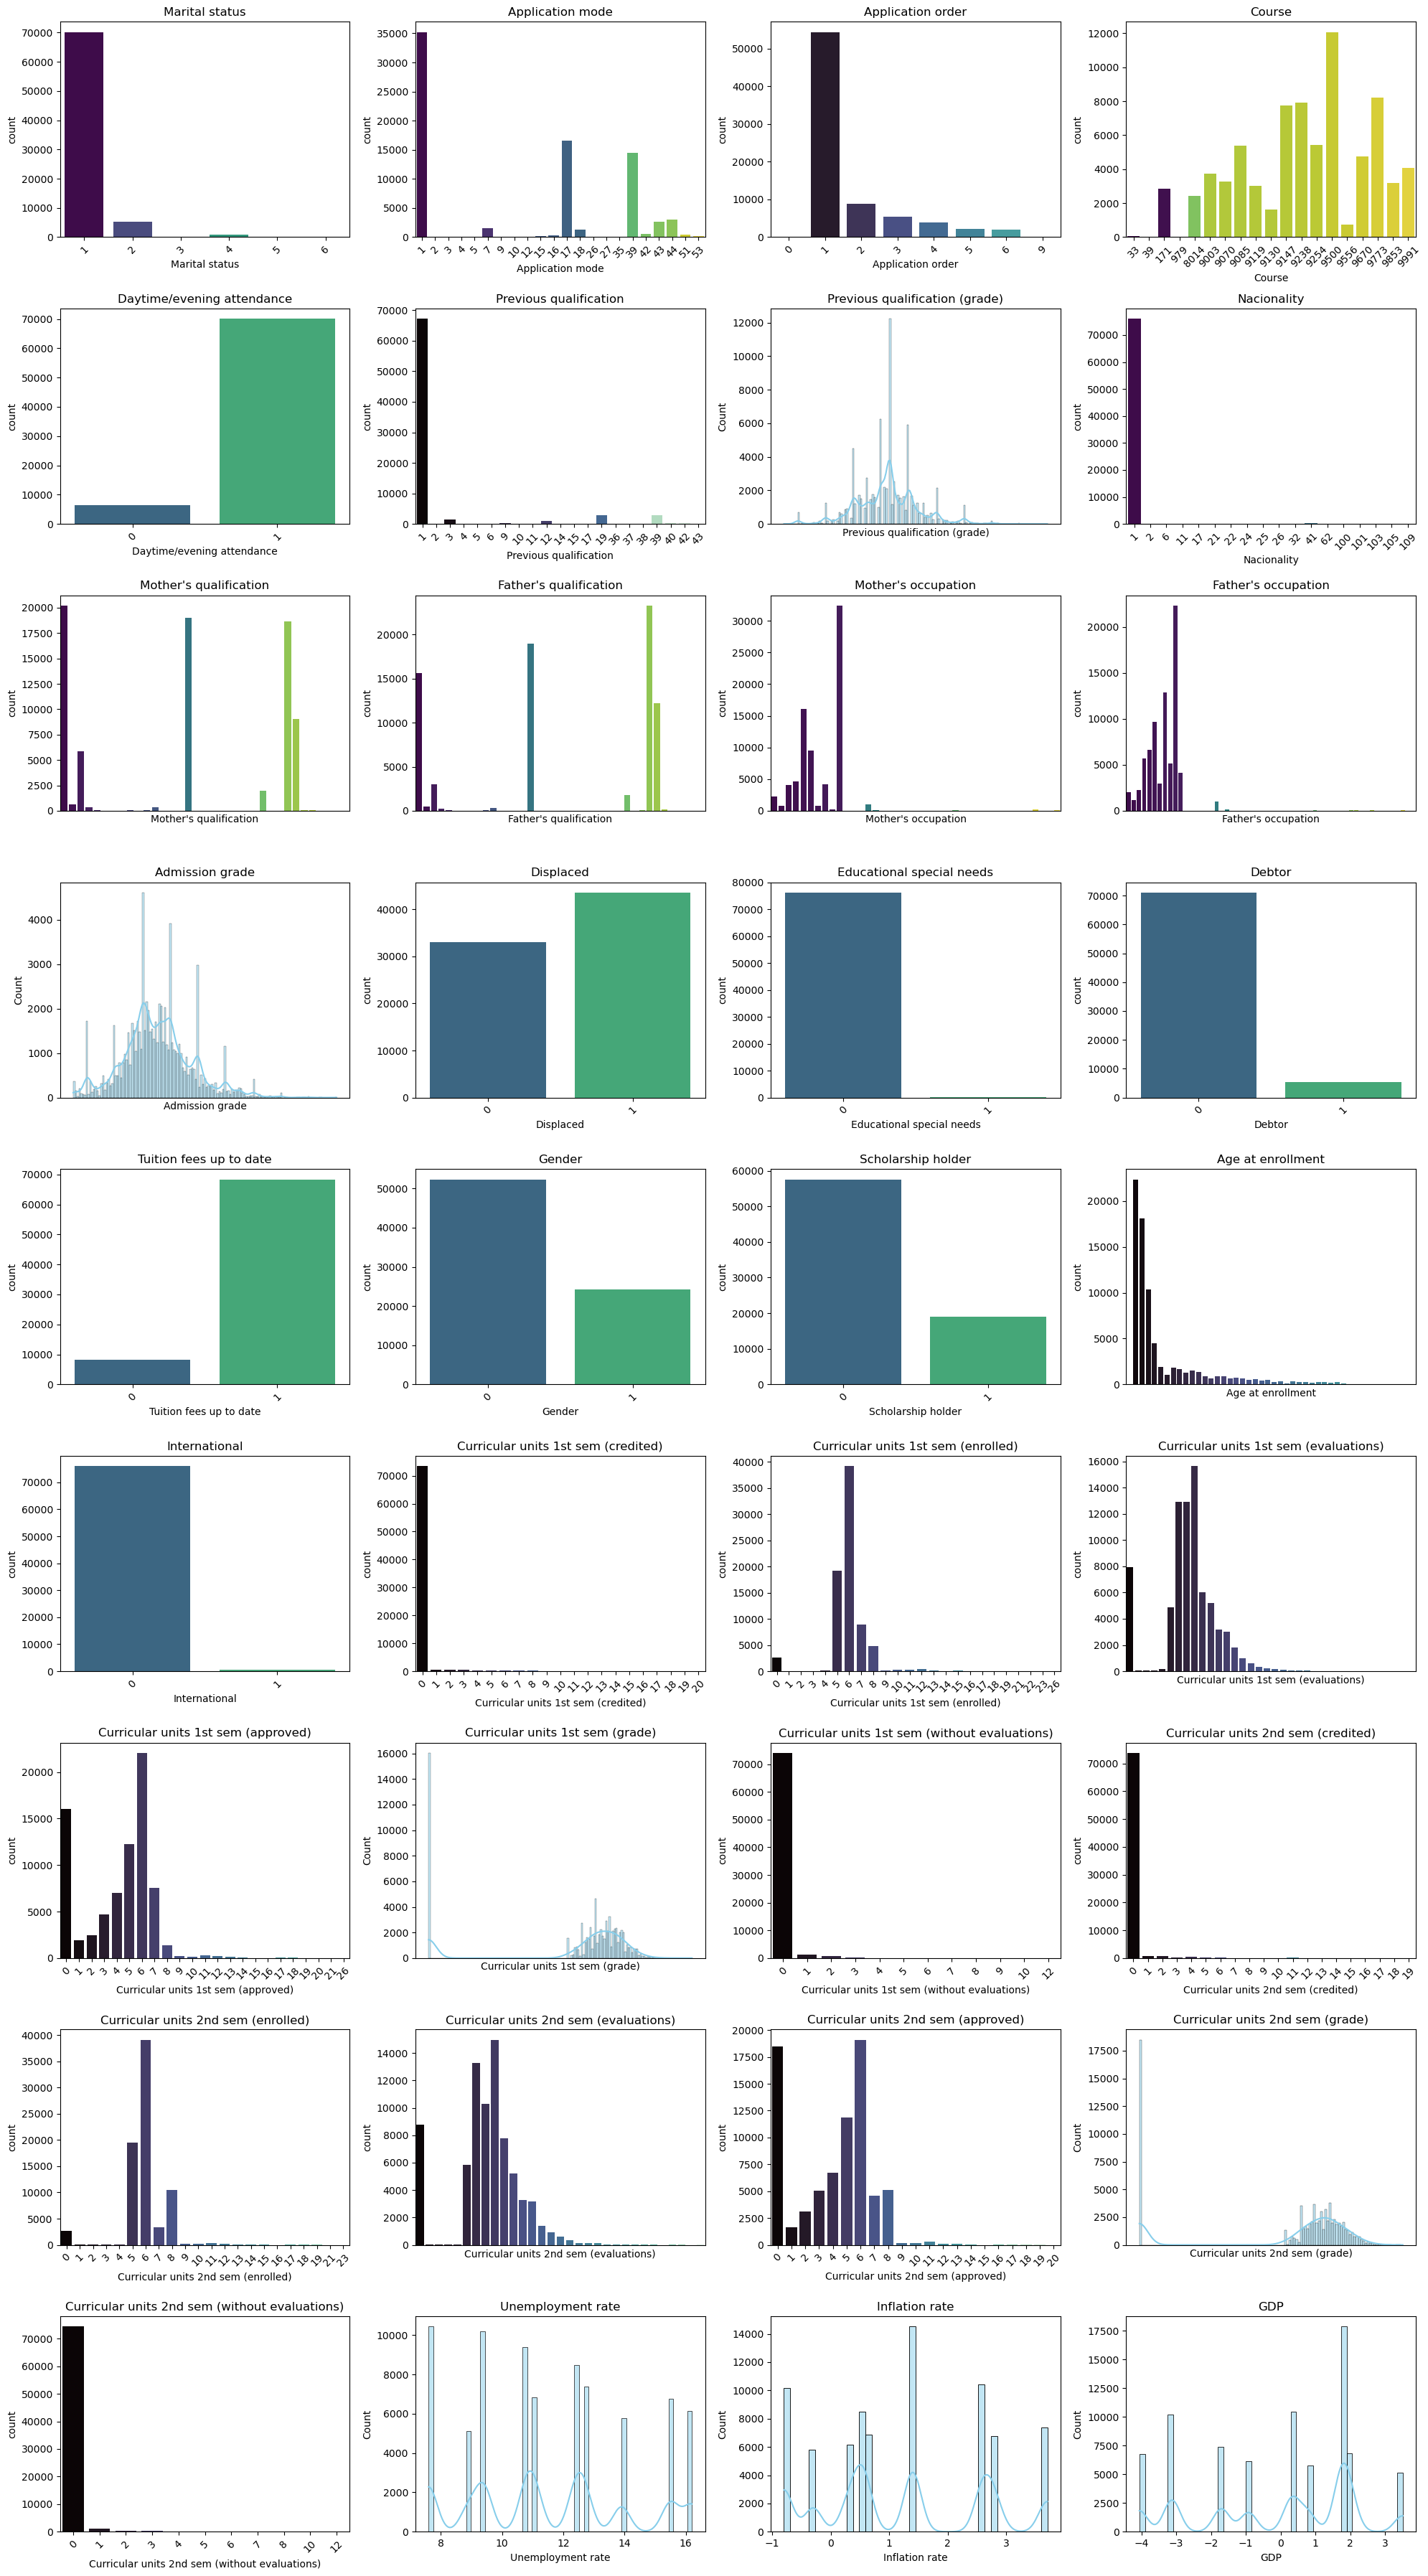

In [12]:
features_to_plot = [col for col in train.columns if col not in ['id', 'Target']]

n_cols = 4
n_rows = int(np.ceil(len(features_to_plot) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, idx)
    unique_count = train[col].nunique()
    hide_xticks = unique_count > 25

    if col in cat_vars:
        sb.countplot(data=train, x=col, hue=col, palette="viridis", legend=False)
        if hide_xticks:
            plt.xticks([])
        else:
            plt.xticks(rotation=45)
    else:
        if train[col].dtype == 'int64':
            sb.countplot(data=train, x=col, hue=col, palette="mako", legend=False)
            if hide_xticks:
                plt.xticks([])
            else:
                plt.xticks(rotation=45)
        elif train[col].dtype == 'float64':
            sb.histplot(train[col], kde=True, color="skyblue")
            if hide_xticks:
                plt.xticks([])
    plt.title(col)
    plt.tight_layout()

plt.show()

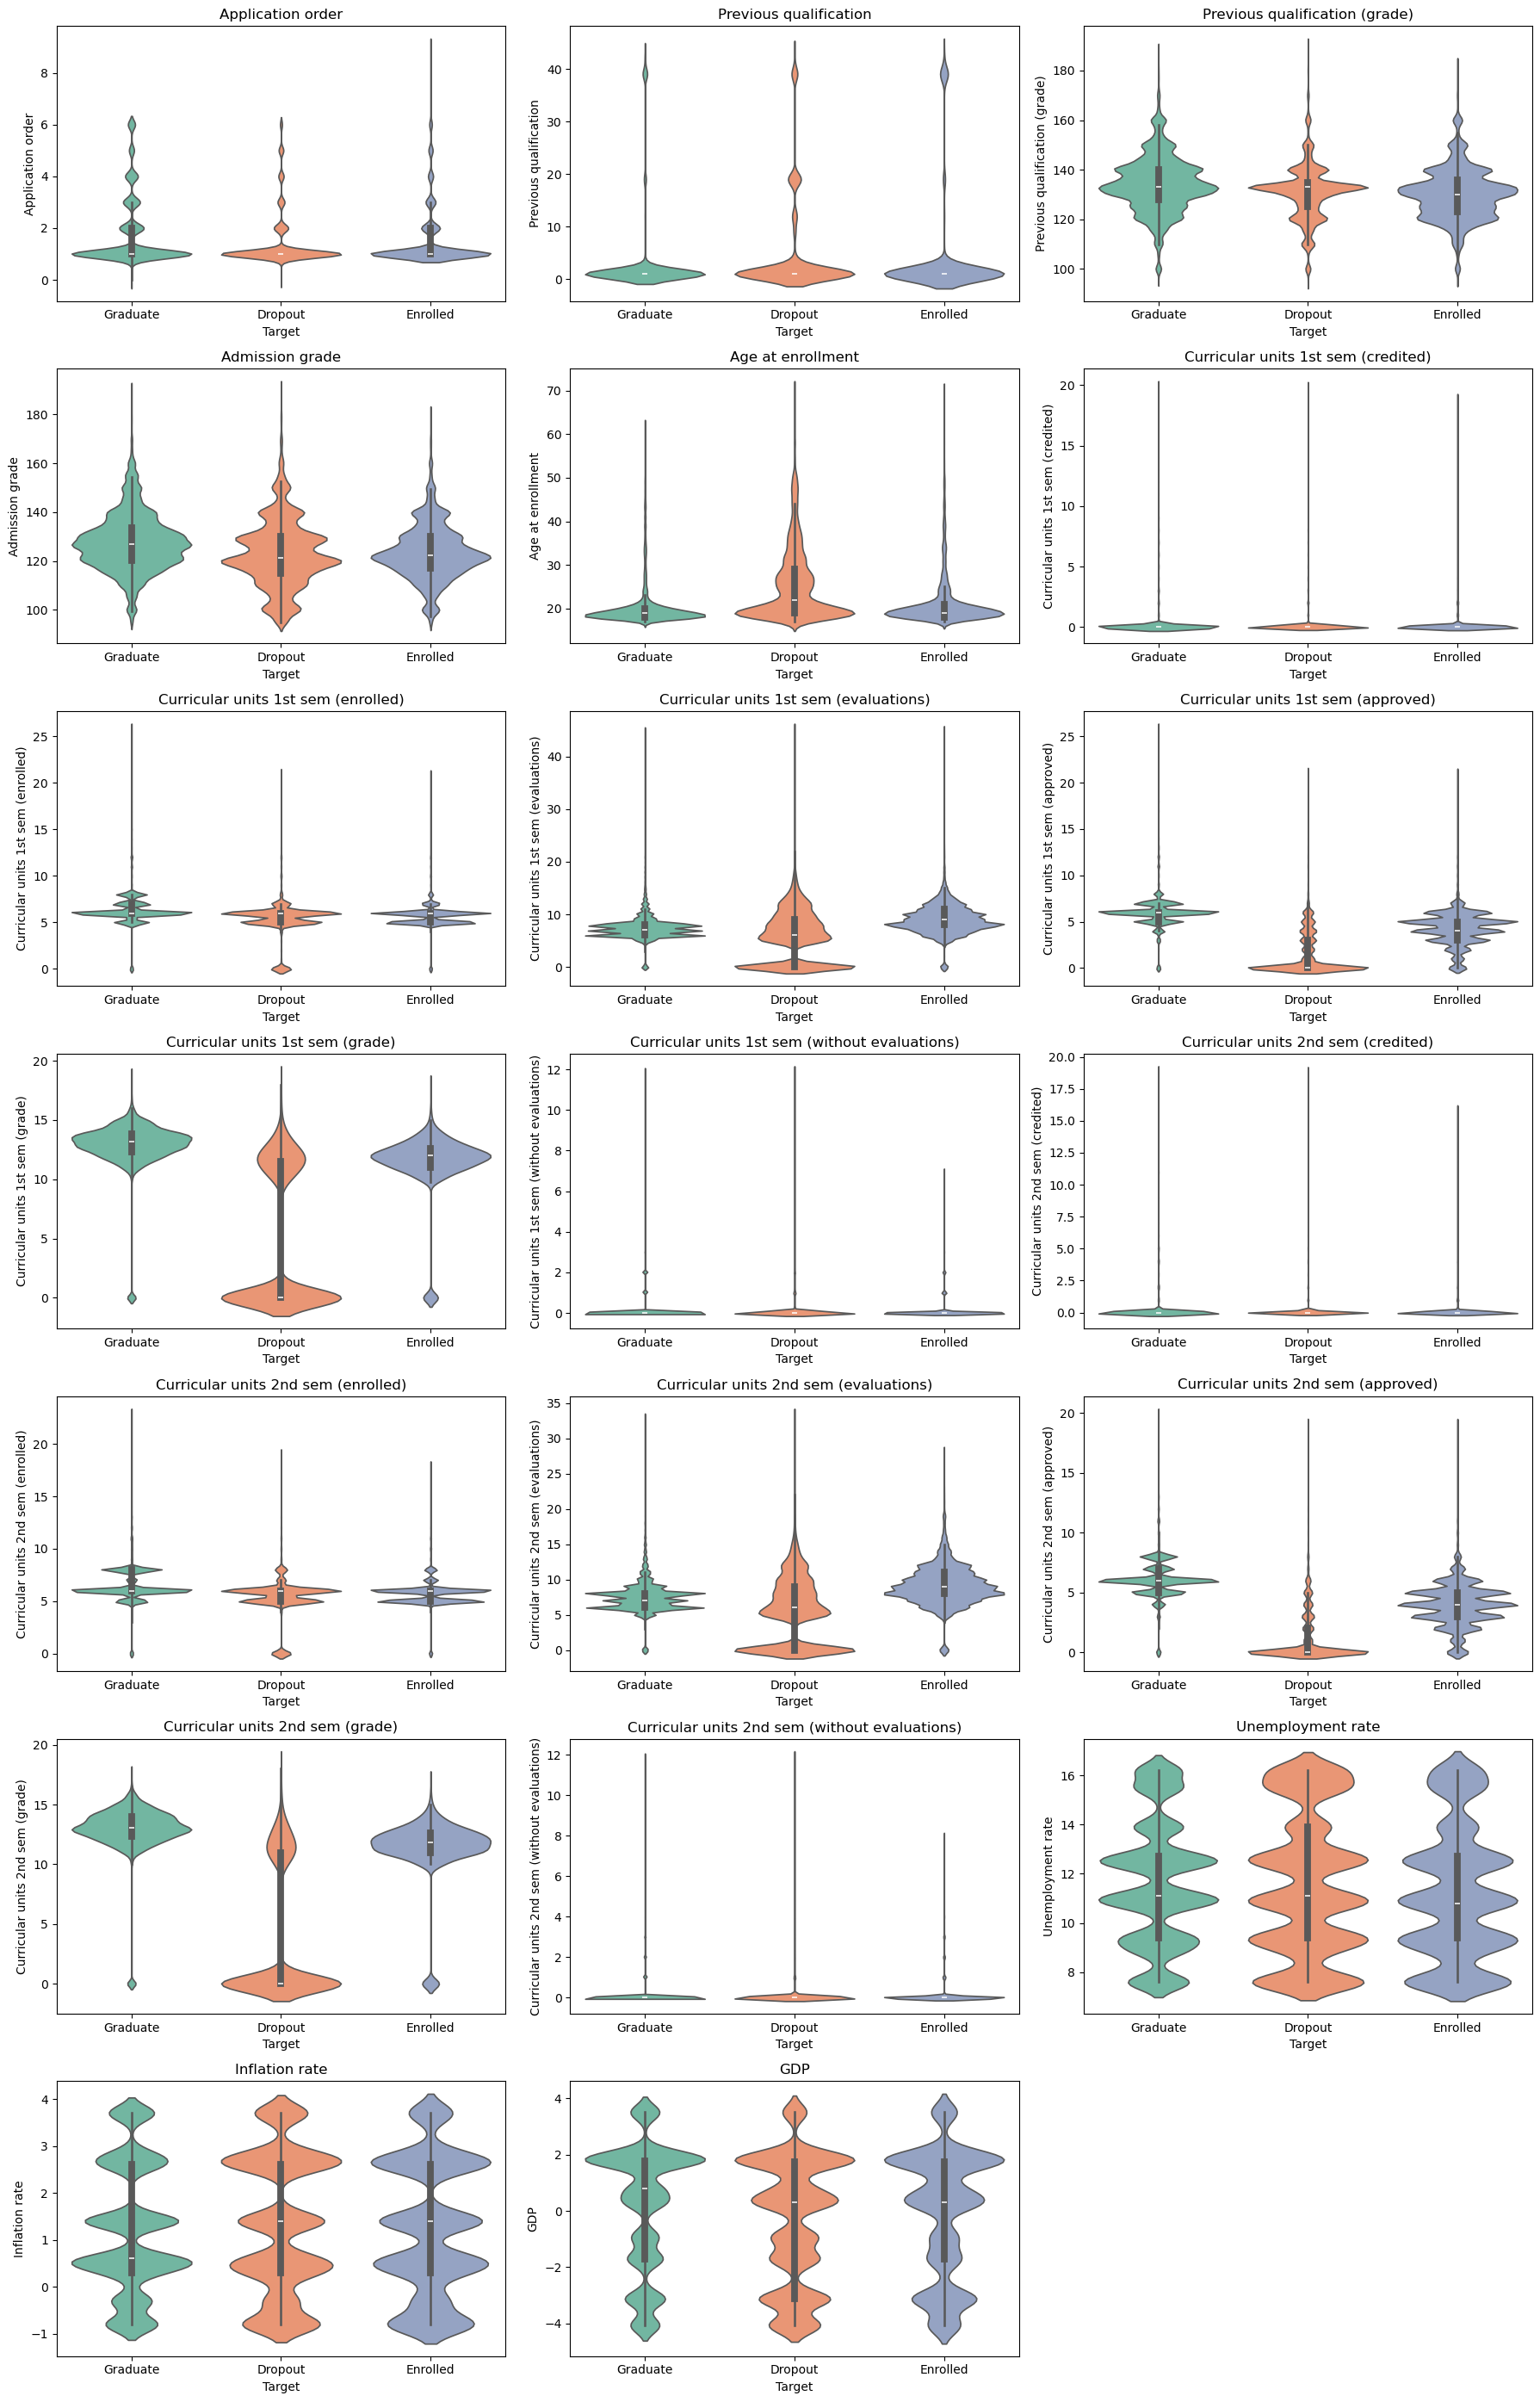

In [11]:
n_cols = 3
n_rows = int(np.ceil(len(num_features) / n_cols))
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for idx, feature in enumerate(num_features, 1):
    plt.subplot(n_rows, n_cols, idx)
    sb.violinplot(data=train, x='Target', y=feature, hue='Target', palette="Set2", legend=False)
    plt.title(feature)

plt.tight_layout()
plt.show()

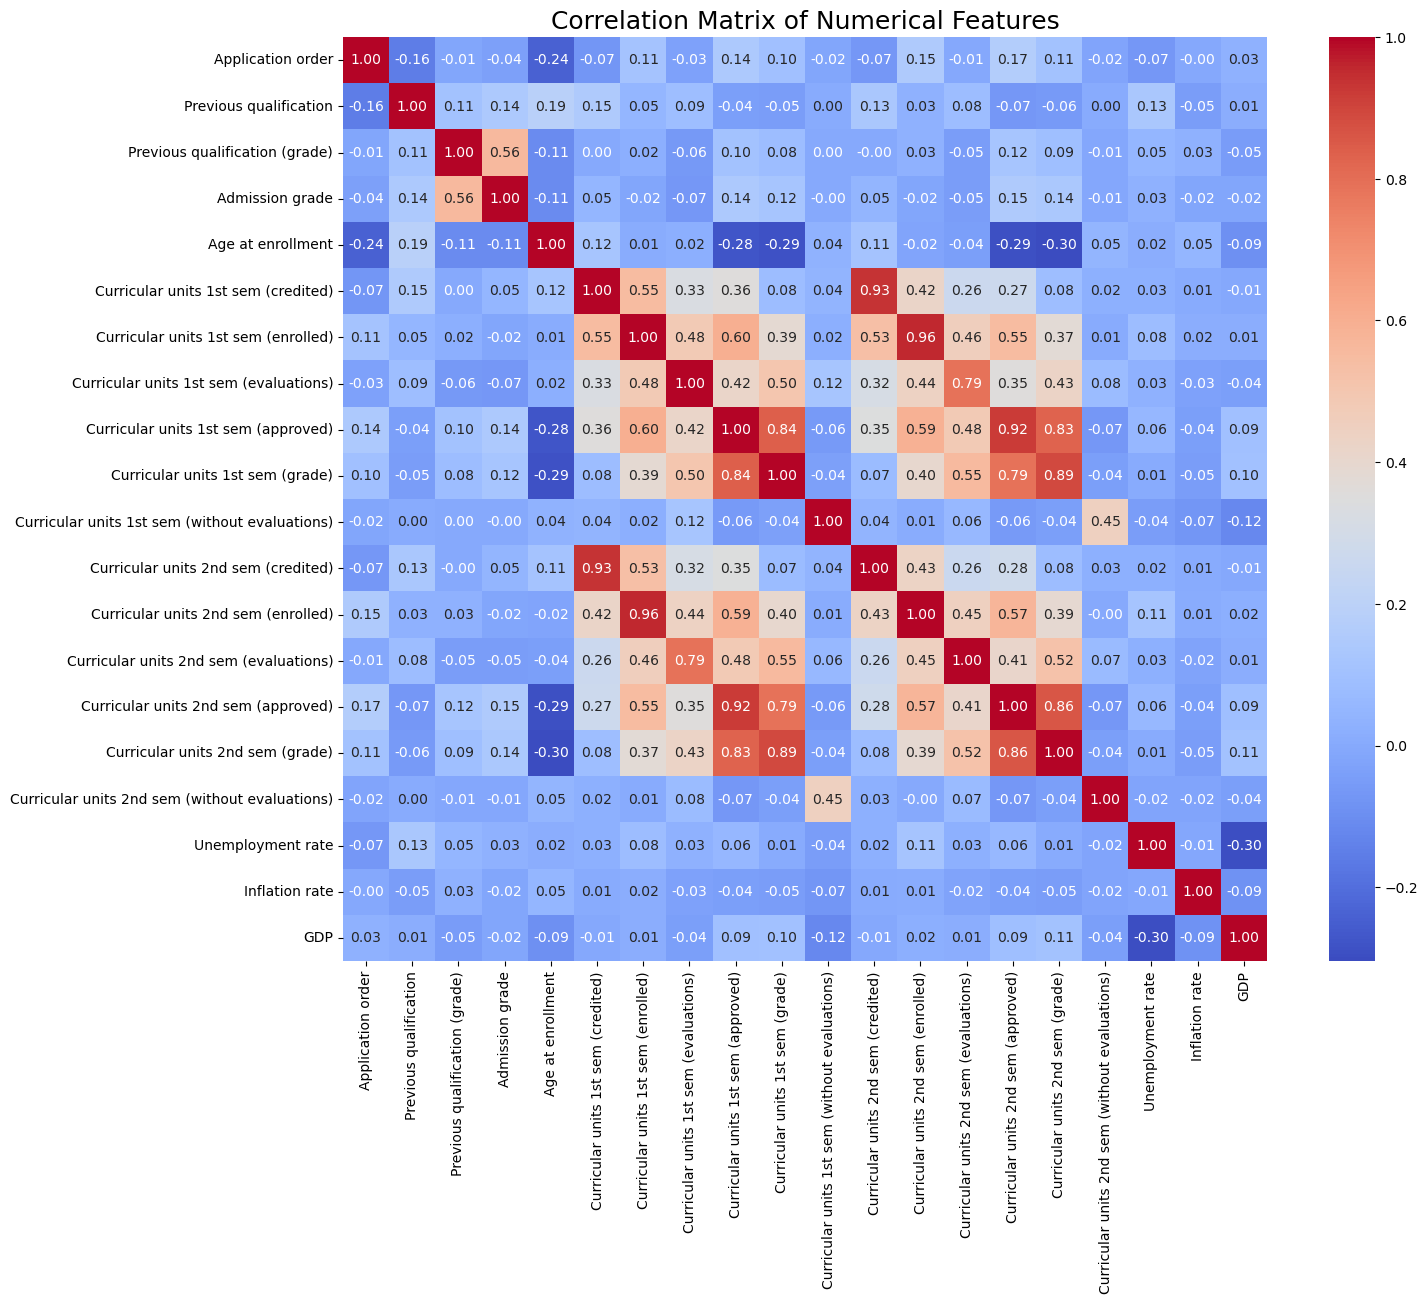

In [10]:
plt.figure(figsize=(16, 12))
corr_matrix = train[num_features].corr()
sb.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numerical Features", fontsize=18)
plt.show()